# Portfolio Analysis of Industrial sector

### Stocks under observation:

    - UPS (NYSE:UPS)
    - Boeing (NYSE:BA)
    - Rockwell Automation Inc. (NYSE:ROK)
    - Honeywell (NYSE:HON)
    - Lockheed Martin (NYSE:LMT)
    - Danaher (NYSE:DHR)


In [39]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader import data as wb
import scipy.optimize as sco
import warnings

warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
np.random.seed(777)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Pulling stock data 

In [40]:
industrial = ['UPS', 'BA', 'ROK', 'HON','LMT', 'DHR' ]
data = pd.DataFrame()
for i in range(len(industrial)):
    
    df = wb.DataReader(industrial[i], data_source='yahoo', start='2020-1-1')
    df['stock'] = industrial[i]
    data = data.append(df[['Adj Close', 'stock']])

table = data.pivot(columns='stock')
# By specifying col[1] in below list comprehension
# You can select the stock names under multi-level column
table.columns = [col[1] for col in table.columns]
table.head()

,BA,DHR,HON,LMT,ROK,UPS
Date,,,,,,
2020-01-02,331.348572,154.894104,178.500671,396.877838,204.597229,115.644112
2020-01-03,330.791901,153.935440,176.595108,411.158142,201.612442,115.574799
2020-01-06,331.766083,154.394806,175.262207,410.532074,203.214279,115.059898
2020-01-07,335.285156,155.912689,175.360947,411.913422,202.796402,114.861862
2020-01-08,329.410095,156.072449,175.509048,408.465057,204.338547,115.515388


Text(0, 0.5, 'price in $')

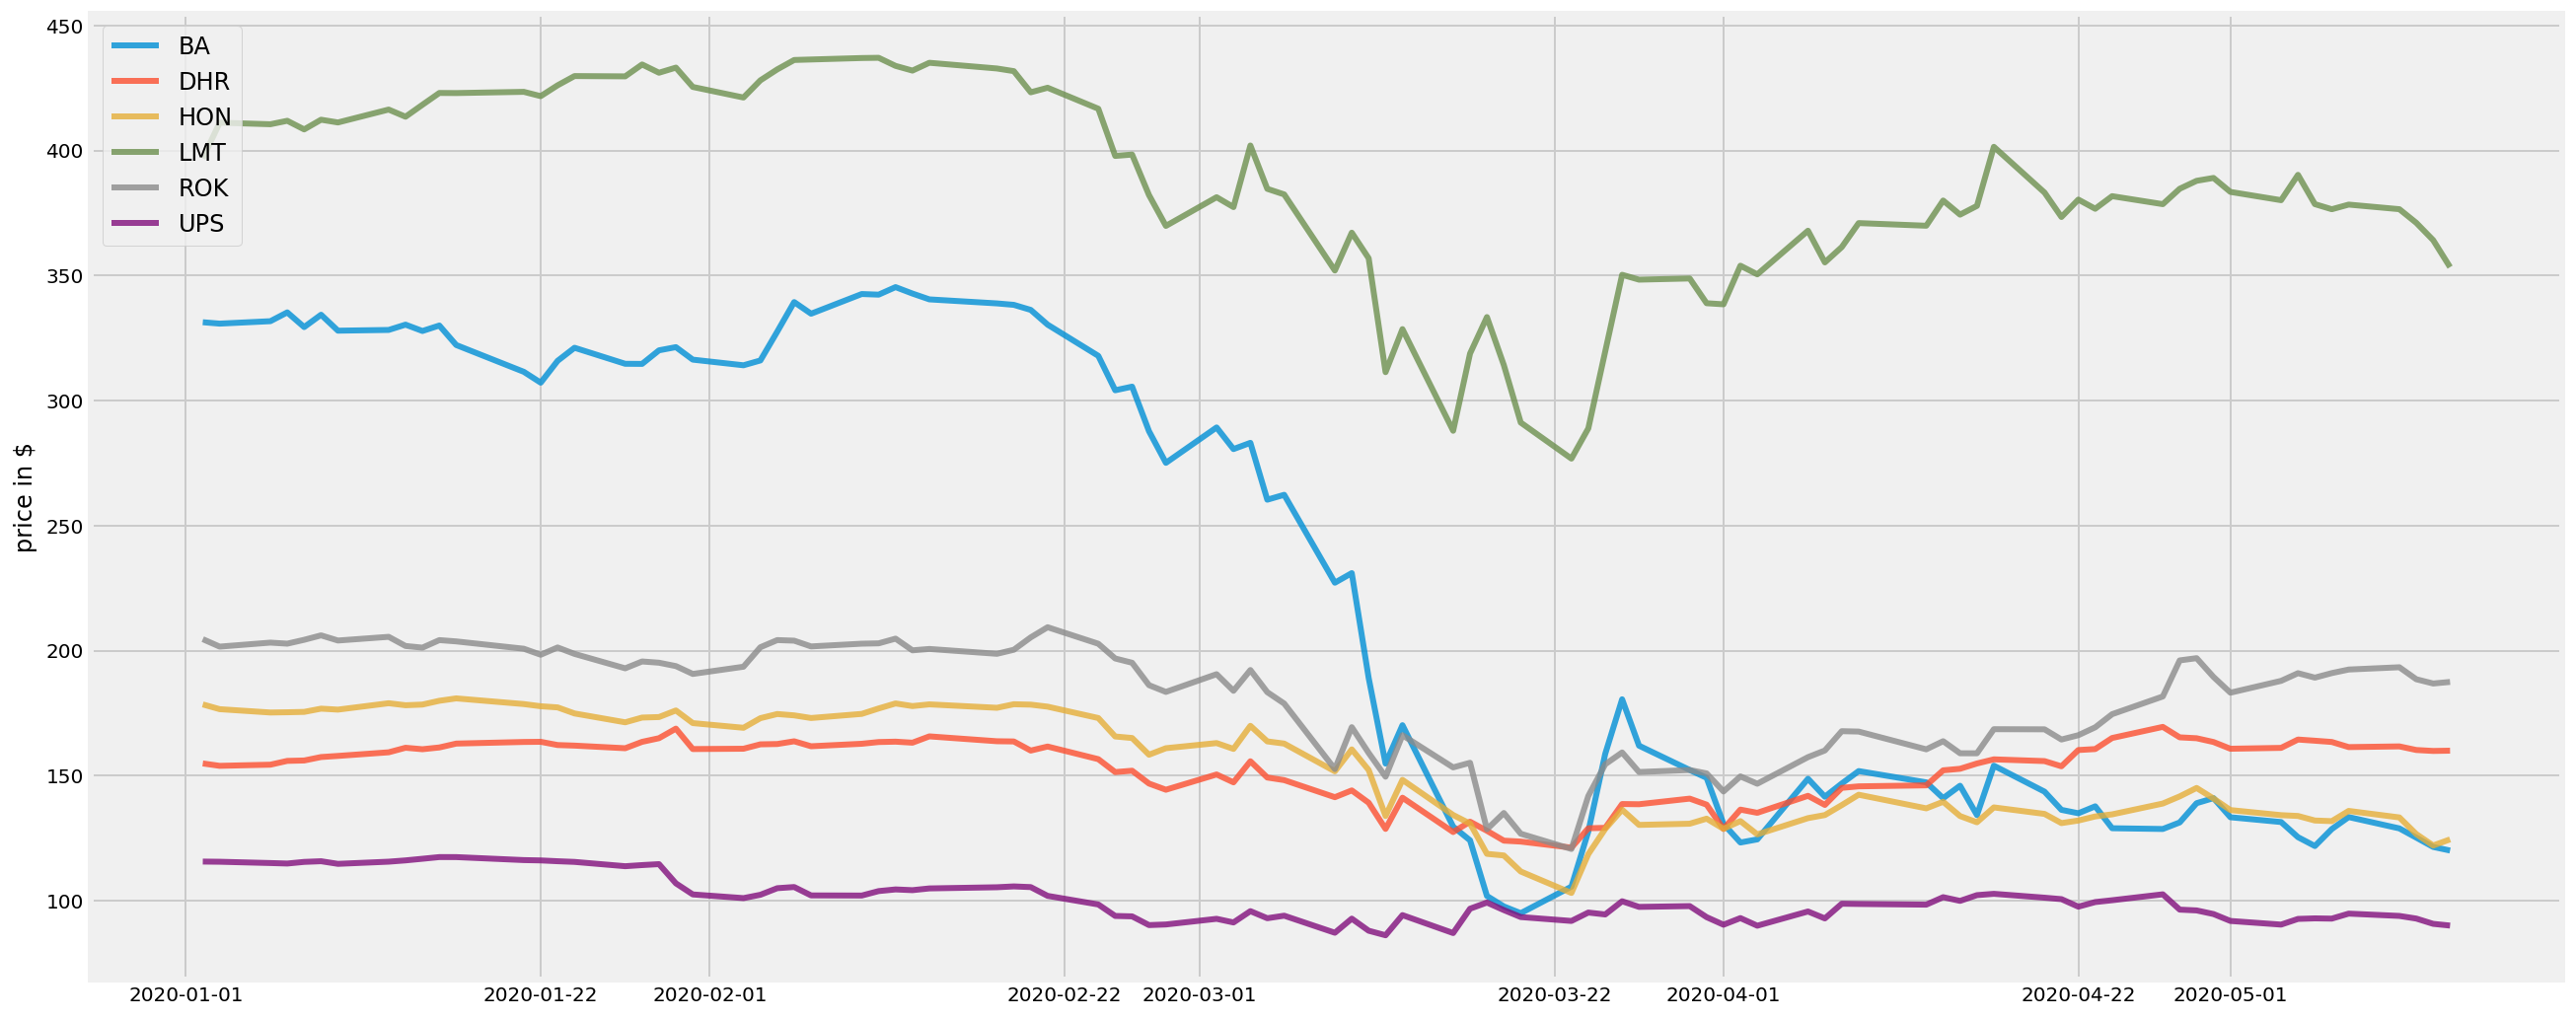

In [41]:
plt.figure(figsize=(20, 9))
for c in table.columns.values:
    plt.plot(table.index, table[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in $')

### Simple returns

Text(0, 0.5, 'daily returns')

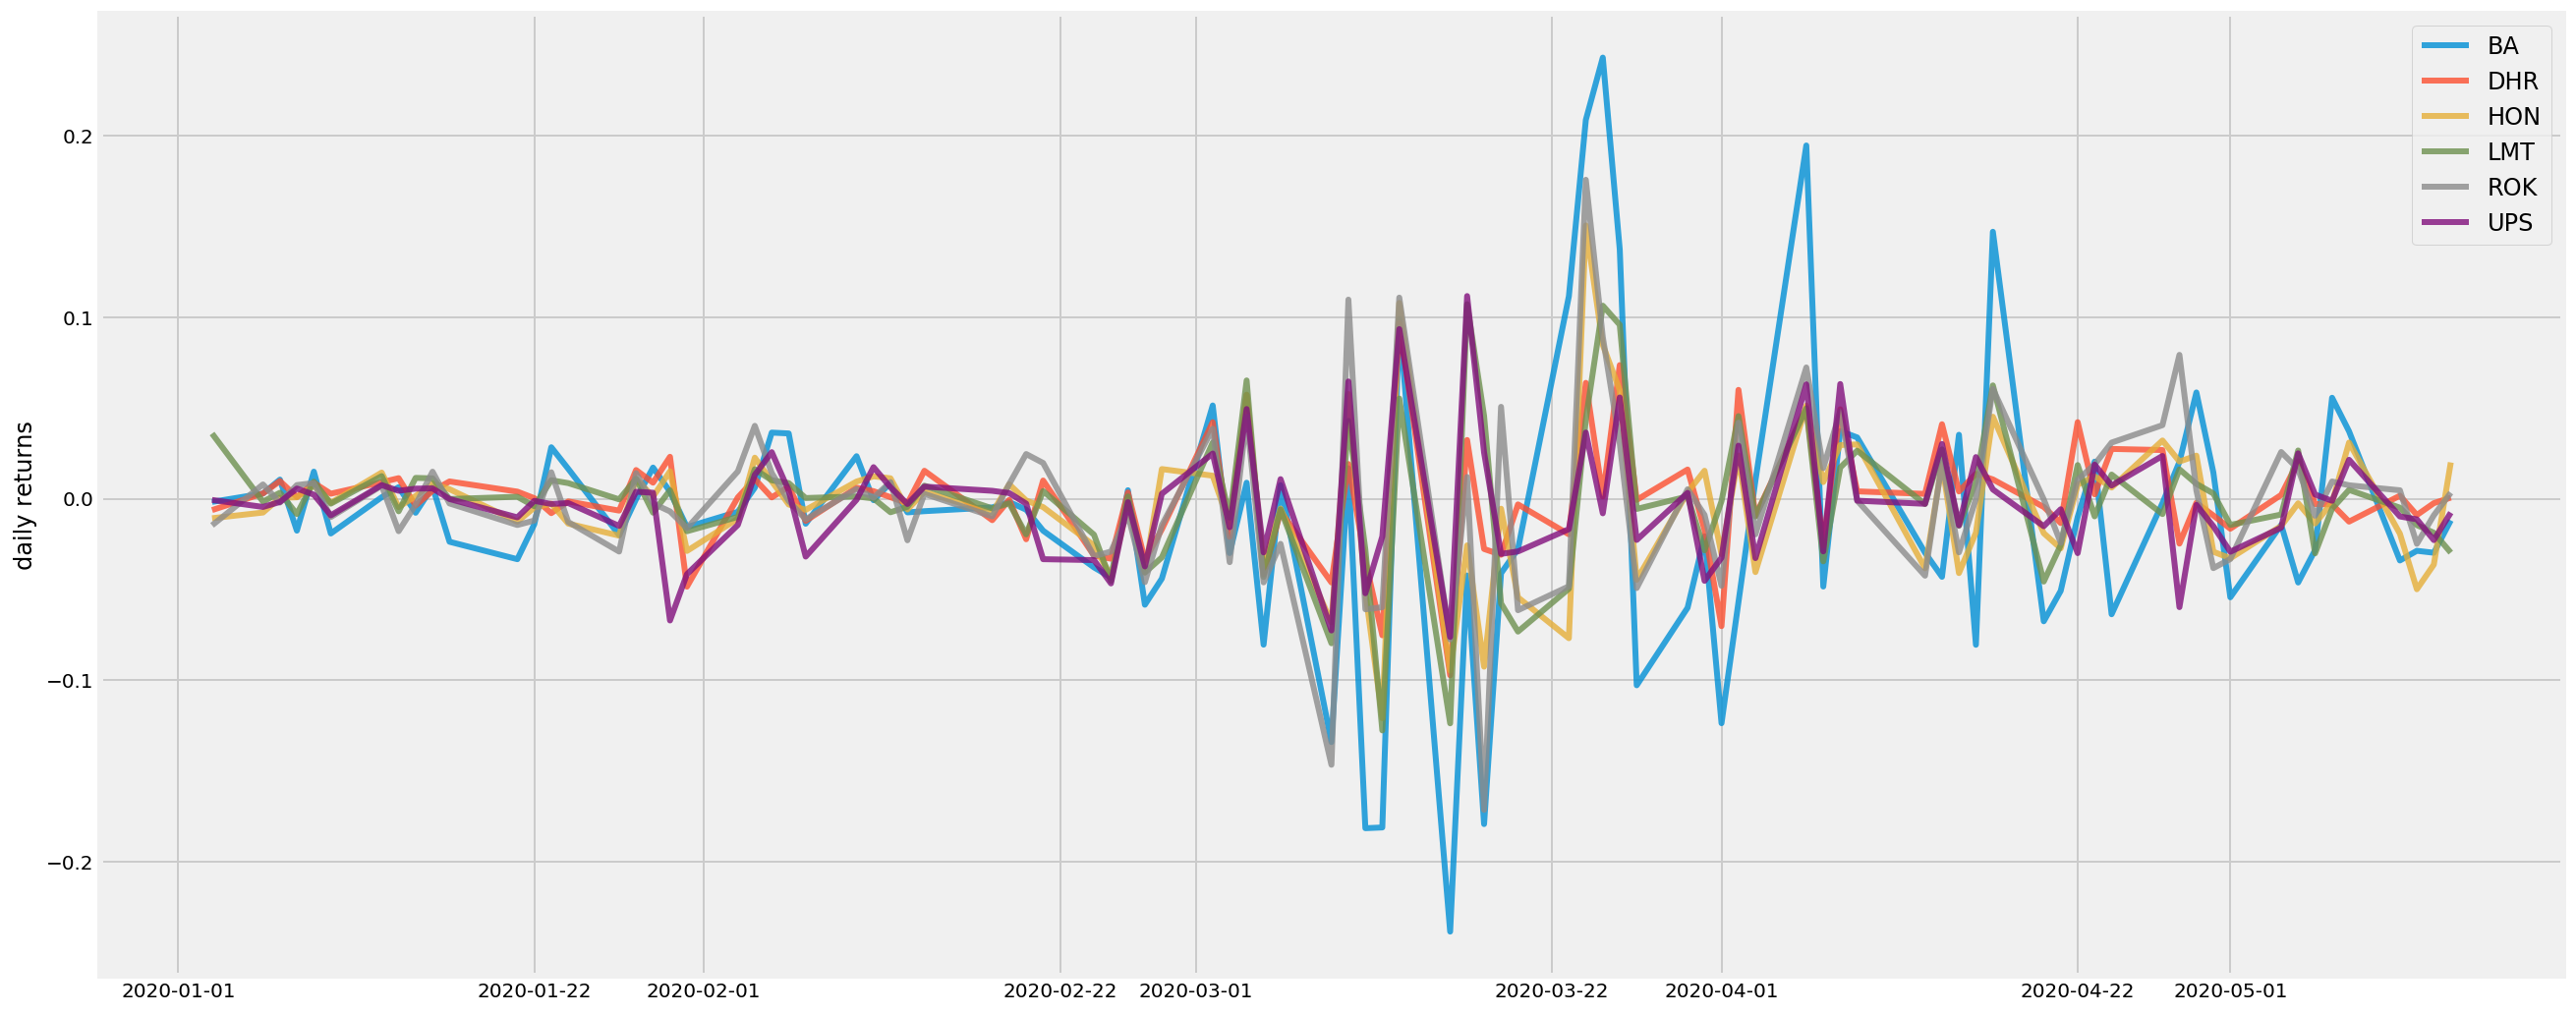

In [42]:
returns = table.pct_change()
plt.figure(figsize=(20, 9))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('daily returns')

### log returns

Text(0, 0.5, 'daily log returns')

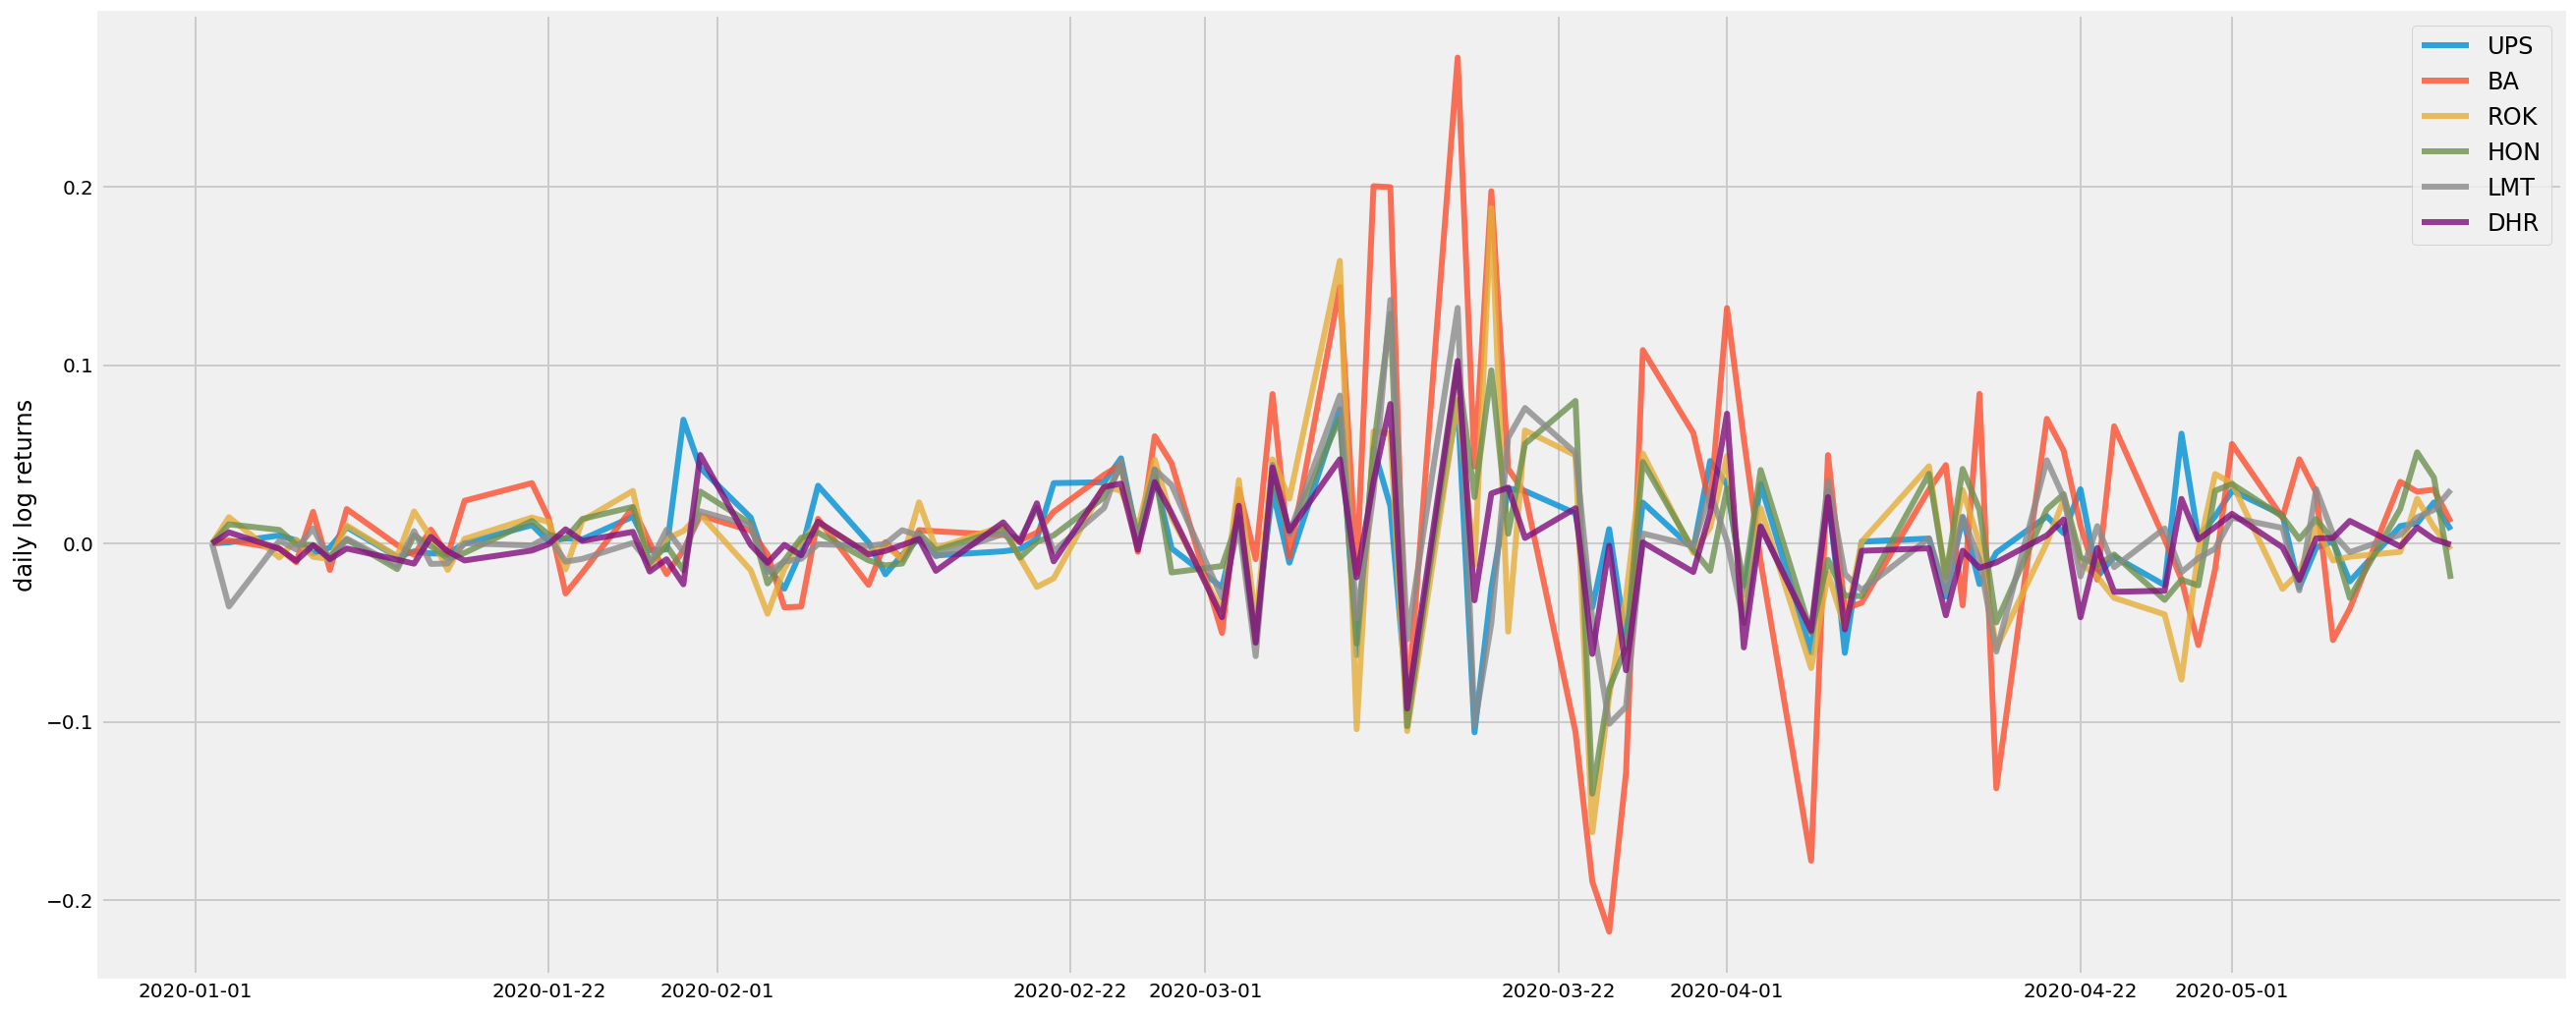

In [43]:
log = pd.DataFrame(columns = industrial, index = table.index)

for i in range(len(industrial)):
    log_list = []
    for j in range(len(table[industrial[i]])):
        if(j+1<len(table[industrial[i]])):
            log_returns =  np.log(table[industrial[i]][j]) - np.log(table[industrial[i]][j+1])
            log_list.append(log_returns)
            

        else:
            None
    log_list.insert(0, 0)   
    log[industrial[i]] = log_list


plt.figure(figsize=(20, 9))
for c in log.columns.values:
     plt.plot(log.index, log[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('daily log returns')


### Normalization to 100

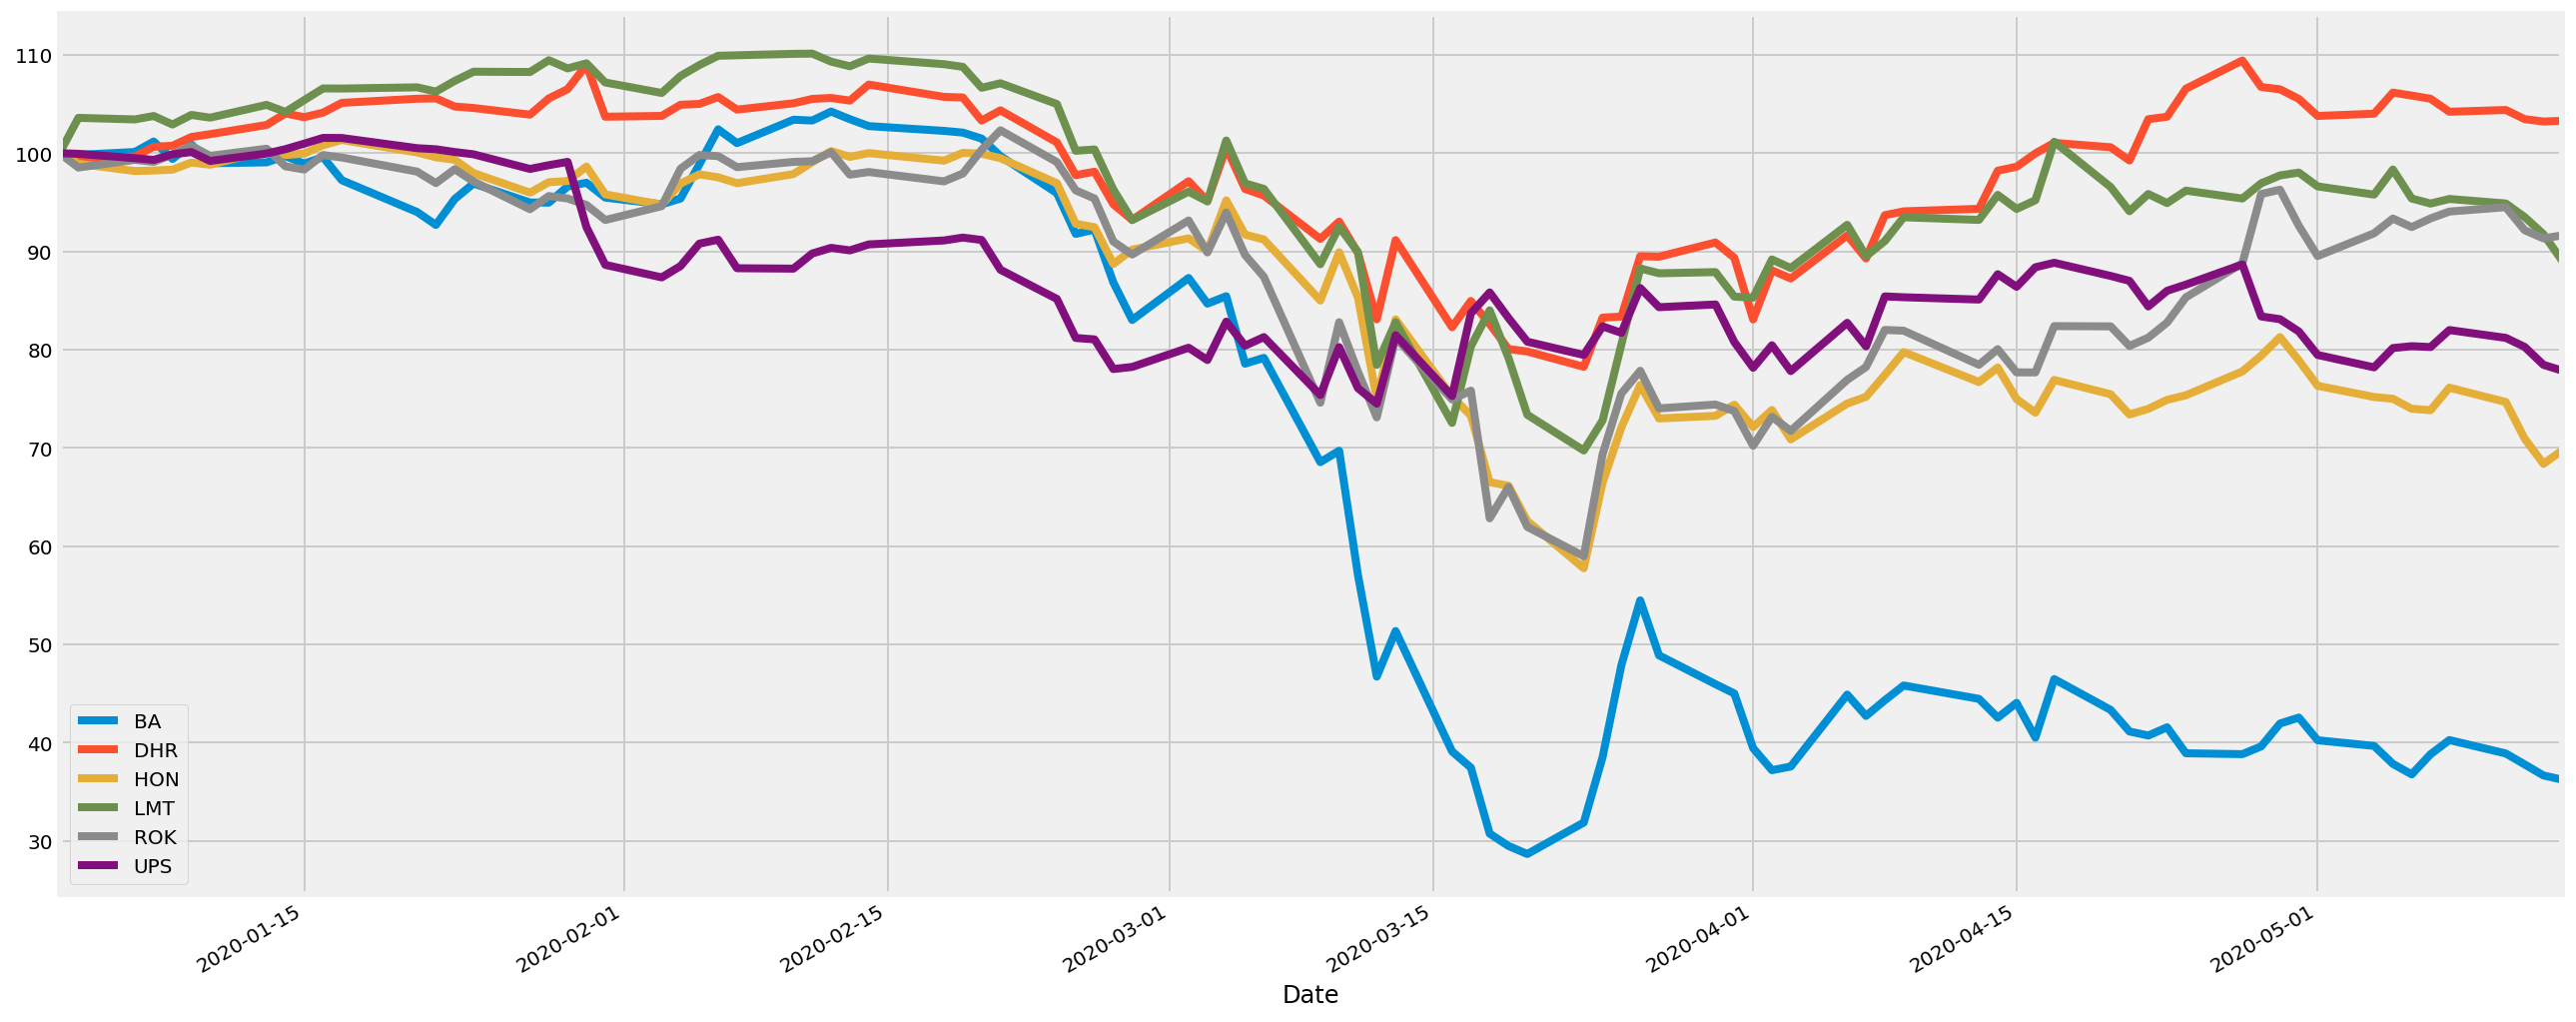

In [44]:
(table/table.iloc[0] * 100).plot(figsize = (20,9))
plt.show()

In [45]:
returns

,BA,DHR,HON,LMT,ROK,UPS
Date,,,,,,
2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,-0.001680,-0.006189,-0.010675,0.035982,-0.014589,-0.000599
2020-01-06,0.002945,0.002984,-0.007548,-0.001523,0.007945,-0.004455
2020-01-07,0.010607,0.009831,0.000563,0.003365,-0.002056,-0.001721
2020-01-08,-0.017523,0.001025,0.000845,-0.008372,0.007604,0.005690
...,...,...,...,...,...,...
2020-05-08,0.037233,-0.012540,0.031027,0.004940,0.007486,0.021545
2020-05-11,-0.033948,0.001735,-0.019210,-0.004863,0.004729,-0.009702
2020-05-12,-0.028625,-0.008905,-0.049821,-0.014473,-0.024772,-0.011287


In [46]:
log.mean()*252

UPS    0.677832
BA     2.750806
ROK    0.236603
HON    0.975825
LMT    0.314475
DHR   -0.087881
dtype: float64

In [47]:
log.std()*252**0.5

UPS    0.495709
BA     1.158360
ROK    0.729414
HON    0.611324
LMT    0.593591
DHR    0.464760
dtype: float64